# Improved Training of Wasserstein GANs and How to Train Your DRAGAN in Pytorch

Pytorch implementation by Thomas Viehmann, tv@lernapparat.de

## Introduction

Wasserstein GANs have been introduced in [Arjovsky et al: Wasserstein GAN](https://arxiv.org/abs/1701.07875).
There also is a [great summary of the article by Alex Irpan](http://www.alexirpan.com/2017/02/22/wasserstein-gan.html).

Recently, [Gulrajani et al: Improved Training of Wasserstein GANs](https://www.arxiv.org/abs/1704.00028) added a relaxed constraint to the original Wasserstein GAN discriminator training objective. I wrote my take at what is up with that in [Geometric Intuition on Improved Wasserstein GANs](https://lernapparat.de/improved-wasserstein-gan/) and also thought that maybe one could take a step back - namely stick with $|f(x)-f(y)| = |x-y|$ instead of testing $|\nabla f| = 1$ (see the [*Semi-Improved Training of Wasserstein GANs* section](https://lernapparat.de/improved-wasserstein-gan/) for details or the [Notebook](https://github.com/t-vi/pytorch-tvmisc/blob/master/wasserstein-distance/Semi-Improved_Training_of_Wasserstein_GAN.ipynb)).

Update: I have written about [DRAGAN, mistakes in the *semi-improved training* methodology, PRODGAN and SLOGAN](https://lernapparat.de/more-improved-wgan/).

I also include the DRAGAN method of locally (close to the real data) imposing the Lipschitz penalty [Kodali et al: How to Train Your DRAGAN](https://arxiv.org/abs/1705.07215). I provide (my interpretation of) the original sampling procedure for the $\delta$ pertubation (method 4) and my own adaptation using per-model-point standard deviations and a normal randomness (method 5). This is because my impression is that the original sampling is positive only. This observation let me to consider whether it was also possible to just improse the $|\nabla f| = 1$ constraint *on* the real data instead (method 6). I call the latter PRODGAN - Penalty Right On the Data GAN. (Note that PRODGAN is likely not that great an idea, see the linked blog post.)

After some more looking at one-sided penalties, I dubbed the models with one-sided Lipschitz penalty Single-sided Lipschitz Objective GANs or SLOGANs.

Now that pytorch gained support for second derivatives, I wanted to also implement the improved training method directly.

Update: Previous versions reflected that some bits of second derivatives were still missing in master. This is rapidly improving, thanks to the hard work of the pytorch developers.

## Acknowledgement

This is based on the semi-improved notebook, which borrows heavily from the code accompanying the two papers, namely
- https://github.com/martinarjovsky/WassersteinGAN (initialisation, loss calculation and training loop)
- https://github.com/igul222/improved_wgan_training (toy problem data generation and network structure, visualization)
- https://github.com/kodalinaveen3/DRAGAN/ (DRAGAN)

Please see the licenses there and refer to the above when using their code.
I applaud publishing the code with the papers. This was crucial in enabling this exercise.

The first pointer to the DRAGAN I saw was by J. F. Santos sharing [his DRAGAN pytorch implementation](https://github.com/jfsantos/dragan-pytorch) on the Pytorch channel. Thank you!

Adam Paszke of Pytorch helped me with how to do grad of grad and I also learnt a lot from his review of my submission to pytorch autograd.

## Code, code, everone wants code!

Here it is. I have left the semi-improved code in there (`lipschitz_contraint = 1` and `2`), too. Setting `lipschitz_constraint = 3` gets you the improved version, `lipschitz_constraint = 4` the DRAGAN one, `5` DRAGAN with different sampling of the perturbation, `6` PRODGAN

For SLOGAN choose `lipschitz_constraint = 1` or `2` and `one_sided = True`.

I updated the code to be able to specify `lipschitz_constraint`, `onesided` and `penalty_weight` in calls to a training function in order to run several models in an efficient way.

In [165]:
# import everything
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable
import os
import numpy
import sklearn
import sklearn.datasets

from matplotlib import pyplot
from matplotlib import gridspec
%matplotlib inline
import IPython
from datetime import datetime as dt
import pandas as pd

# insert this to the top of your scripts (usually main.py)
import sys, warnings, traceback, torch
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    sys.stderr.write(warnings.formatwarning(message, category, filename, lineno, line))
    traceback.print_stack(sys._getframe(2))
warnings.showwarning = warn_with_traceback; warnings.simplefilter('always', UserWarning);
torch.utils.backcompat.broadcast_warning.enabled = True
torch.utils.backcompat.keepdim_warning.enabled = True

In [166]:
# set up parameters, a blend of Wasserstein GAN and Improved Training's code
# to get SLOGAN choose constraint 1 or 2 and opt_onesided = True, other named models use opt_onesided = False

names = ["plain WGAN", "semi-improved WGAN method 1 (WGAN-LP1)", 
         "semi-improved WGAN method 2 (WGAN-LP2)",
         "improved training of WGAN (WGAN-GP)", 
         "DRAGAN", 
         "DRAGAN improved sampling", 
         "PRODGAN", 
         "DRAGAN improved sampling + both perturbed"]

shortnames = ["WGAN", "WGAN-LP1", "WGAN-LP2", "WGAN-GP", "DRAGAN", "DRAGAN-G", "PRODGAN", "DRAGAN-G-2"]

opt_lipschitz_constraint = 6 # 0: original WGAN, 1: semi-improved method 1
                          # 2: semi-improved method 2
                          # 3: improved method with gradient penalty
                          # 4: DRAGAN 5: DRAGAN with improved perturbation sampling
                          # 6: PRODGAN

opt_onesided = False     # use two-sided or one-sided constraint

opt_penalty_weight = 10.0 # penalty weight term lambda

opt_dataset = 'swissroll' # 8gaussians | swissroll | 25gaussians
opt_niter = 5000
opt_batchSize=256
opt_lrD = 0.00005 # learning rate for Critic, default=0.00005
opt_lrG = 0.00005 # learning rate for Generator, default=0.00005
opt_beta1=0.5 # beta1 for adam. default=0.5
opt_cuda = True
opt_clamp_lower = -0.01 #default -0.01
opt_clamp_upper =  0.01 #default  0.01
opt_Diters = 10 # number of D iters per each G iter
opt_adam = False  # Whether to use adam (default False is rmsprop)
opt_prefix = None # whether to write images (=prefix of type string) or show in notebook (=None)

opt_manualSeed = 15042017
print("Random Seed: ", opt_manualSeed)
random.seed(opt_manualSeed)
numpy.random.seed(opt_manualSeed)
torch.manual_seed(opt_manualSeed)
cudnn.benchmark = True

('Random Seed: ', 15042017)


In [167]:
# Dataset generator largely form Improved Training of Wasserstein GAN code (see link above)
def inf_train_gen(DATASET='8gaussians', BATCH_SIZE=opt_batchSize):
    numpy.random.seed(1234)
    if DATASET == '25gaussians':
        dataset = []
        for i in range(100000//25):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = numpy.random.randn(2)*0.05
                    point[0] += 2*x
                    point[1] += 2*y
                    dataset.append(point)
        dataset = numpy.array(dataset, dtype='float32')
        numpy.random.shuffle(dataset)
        dataset /= 2.828 # stdev
        while True:
            for i in range(len(dataset)//BATCH_SIZE):
                yield torch.from_numpy(dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE, 
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5 # stdev plus a little
            yield torch.from_numpy(data)

    elif DATASET == '8gaussians':
    
        scale = 2.
        centers = [
            (1,0),
            (-1,0),
            (0,1),
            (0,-1),
            (1./numpy.sqrt(2), 1./numpy.sqrt(2)),
            (1./numpy.sqrt(2), -1./numpy.sqrt(2)),
            (-1./numpy.sqrt(2), 1./numpy.sqrt(2)),
            (-1./numpy.sqrt(2), -1./numpy.sqrt(2))
        ]
        centers = [(scale*x,scale*y) for x,y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = numpy.random.randn(2)*.02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = numpy.array(dataset, dtype='float32')
            dataset /= 1.414 # stdev
            yield torch.from_numpy(dataset)

In [168]:
ds1 = [next(inf_train_gen("swissroll")) for i in range(100)]
ds2 = [next(inf_train_gen("swissroll")) for i in range(100)]
for ds1e, ds2e in zip(ds1, ds2):
    assert(numpy.allclose(ds1e.numpy(), ds2e.numpy()))

In [169]:
# Generates and saves a plot of the true distribution, the generator, and the
# critic.
# largely form Improved Training of Wasserstein GAN code (see link above)
class ImageGenerator:
  def __init__(self, netG, netD, prefix='frame', noise_dim=2):
    self.prefix = prefix
    self.frame_index = 1
    self.noise_dim = noise_dim
    self.netG = netG
    self.netD = netD
    
  def __call__(self, true_dist, perturbed, losses):
    try:
        N_POINTS = 128
        RANGE = 2

        points = numpy.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
        points[:,:,0] = numpy.linspace(-RANGE, RANGE, N_POINTS)[:,None]
        points[:,:,1] = numpy.linspace(-RANGE, RANGE, N_POINTS)[None,:]
        points = points.reshape((-1,2))
        points = Variable(torch.from_numpy(points).cuda())

        noise = torch.FloatTensor().resize_(opt_batchSize, 2)
        noise.normal_(0, 1)
        noise = Variable(noise.cuda())

        fake = self.netG(noise)
        samples = fake.data.cpu().numpy()

        disc_points = self.netD(points)

        disc_map = disc_points.data.cpu().numpy()
        disc_map = (disc_map - numpy.min(disc_map)) / numpy.max(disc_map) * 8
        disc_map = numpy.log(disc_map + 0.25)

        pyplot.figure(num=1, figsize=(10,15))
        gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

        pyplot.clf()
        if self.prefix is None:
            #pyplot.suplots(nrows=1, ncols=2)
            pyplot.subplot(gs[0])
        x = y = numpy.linspace(-RANGE, RANGE, N_POINTS)
        pyplot.contour(x,y,disc_map.reshape((len(x), len(y))).T)

        true_dist = true_dist.cpu().numpy()
        perturbed = perturbed.cpu().numpy()
        pyplot.scatter(true_dist[:, 0], true_dist[:, 1], c='orange',marker='+')
        pyplot.scatter(perturbed[:, 0], perturbed[:, 1], c='red', marker='+')
        pyplot.scatter(samples[:, 0],   samples[:, 1],   c='green', marker='*')
        if self.prefix is not None:
          pyplot.savefig(self.prefix+'{:05d}'.format(self.frame_index)+'.jpg')
        else:
          pyplot.subplot(gs[1])
          pyplot.plot(losses)
          IPython.display.clear_output(wait=True)
          IPython.display.display(pyplot.gcf())
        self.frame_index += 1
    except Exception:
        print("some exception occurred while plotting")

Define the Generator and Critic, I use my own LeakyReLU until second derivatives are available for the standard one.

In [170]:
class MyLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.01):
        super(MyLeakyReLU, self).__init__()
        self.negative_slope = negative_slope
    def forward(self, x):
        return torch.clamp(x, min=0.0)+torch.clamp(x, max=0.0)*self.negative_slope

class ToyGAN_G(nn.Module):
    def __init__(self, dim_hidden=512, dim_out=2, noise_dim=2):
        super(ToyGAN_G, self).__init__()
        self.dim_hidden, self.dim_out, self.noise_dim = dim_hidden, dim_out, noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_out)
            )
    def forward(self, x):
        x = self.net(x)
        return x

class ToyGAN_D(nn.Module):
    def __init__(self, dim_hidden=512, dim_gen_out=2):
        super(ToyGAN_D, self).__init__()
        self.dim_hidden, self.dim_gen_out = dim_hidden, dim_gen_out
        self.net = nn.Sequential(
            nn.Linear(dim_gen_out, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, 1)
            )
    def forward(self, x): #?
        x = self.net(x)
        return x

Do the training (code largely taken from Wasserstein GAN code, see link above).
As suspected in an earlier version, there was room for improvement in how to express the loss function in pytorch. A very warm thank you to Adam Paszke for showing the correct way to do it and "live" fixing a bug I hit (if you get `RuntimeError: Cublas_Sgemv only supports m, n, lda, incx, incyin the range 0 < [val] <= 2147483647` you need to update pytorch, too). (Edit: Apparently there also is a bug w.r.t. the output in Jupyter notebook. If the kernel crashes, you might try to convert the code to regular python instead.)

In [171]:
def run_experiment(lipschitz_constraint = opt_lipschitz_constraint,
                   onesided = opt_onesided,
                   penalty_weight = opt_penalty_weight, 
                   perturb_both = False,   # only works with lc 4 and 5
                   perturb_symmetric = False, # only works with lc 4 (DRAGAN), which is not symmetric by default
                   perturb_scale=1.,        # only works with lc 4 and 5
                   niter=opt_niter, 
                   data_pregenerate=False):
    if lipschitz_constraint == 7:
        lipschitz_constraint = 5
        perturb_both = True

    if onesided:
        clip_fn = lambda x: x.clamp(max=0)
    else:
        clip_fn = lambda x: x
    if onesided and (lipschitz_constraint == 1 or lipschitz_constraint == 2):
        name = "SLOGAN simple method {}".format(lipschitz_constraint)
    else:
        name = names[lipschitz_constraint]

    # set up tensors (torch administrativa)
    input = torch.FloatTensor(opt_batchSize, 2)
    input2 = torch.FloatTensor(opt_batchSize, 2)
    interp_alpha = torch.FloatTensor(opt_batchSize, 1)
    noise = torch.FloatTensor(opt_batchSize, 2)
    fixed_noise = torch.FloatTensor(opt_batchSize, 2).normal_(0, 1)
    perturbation = torch.FloatTensor(opt_batchSize,2)
    if perturb_both:
      perturbation2 = torch.FloatTensor(opt_batchSize, 2)
    one = torch.FloatTensor([1])
    mone = one * -1

    if opt_cuda:
        input = input.cuda()
        input2 = input2.cuda()
        interp_alpha = interp_alpha.cuda()
        one, mone = one.cuda(), mone.cuda()
        noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
        perturbation = perturbation.cuda()
        if perturb_both:
            perturbation2 = perturbation2.cuda()


    data_generator = inf_train_gen(opt_dataset)
    if data_pregenerate:
        data_generator = iter([next(data_generator) for i in range(niter)])   # generate batches now
    netD = ToyGAN_D()
    netG = ToyGAN_G()
    netD.cuda()
    netG.cuda()

    generate_image = ImageGenerator(netG, netD, prefix=opt_prefix)

    if opt_adam:
        optimizerD = optim.Adam(netD.parameters(), lr=opt_lrD, betas=(opt_beta1, 0.999))
        optimizerG = optim.Adam(netG.parameters(), lr=opt_lrG, betas=(opt_beta1, 0.999))
    else:
        optimizerD = optim.RMSprop(netD.parameters(), lr = opt_lrD)
        optimizerG = optim.RMSprop(netG.parameters(), lr = opt_lrG)

    losses = []
    errD_seq = []
    errG_seq = []
    scoreD_real_seq = []
    scoreD_fake_seq = []
    lip_loss_seq = []
    for batches in range(niter):
        vinput = Variable(input, requires_grad=(opt_lipschitz_constraint==6))
        vinput2 = Variable(input2)
        vnoise = Variable(noise)
        vfixed_noise = Variable(fixed_noise)


        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update

        # train the discriminator Diters times
        if batches < 25 or batches % 500 == 0:
            Diters = 100
        else:
            Diters = opt_Diters
        for j in range(Diters):

            if lipschitz_constraint == 0:
                # clamp parameters to a cube
                for p in netD.parameters():
                    p.data.clamp_(opt_clamp_lower, opt_clamp_upper)

            data = next(data_generator)
            perturbedreal = None

            # train with real
            real_cpu = data
            netD.zero_grad()
            batch_size = real_cpu.size(0)
            vinput.data.resize_(real_cpu.size()).copy_(real_cpu)

            scoreD_real_vec = netD(vinput)
            scoreD_real = scoreD_real_vec.mean(0, keepdim=False).view(1)
            scoreD_real.backward(one, retain_graph=(lipschitz_constraint>0))

            # train with fake
            vnoise.data.resize_(batch_size, 2)
            vnoise.data.normal_(0, 1)
            fake = netG(vnoise)
            vinput2.data.resize_(fake.data.size()).copy_(fake.data)
            scoreD_fake_vec = netD(vinput2)
            scoreD_fake = scoreD_fake_vec.mean(0, keepdim=False).view(1)
            scoreD_fake.backward(mone, retain_graph=(lipschitz_constraint>0))
            errD = scoreD_real - scoreD_fake
            # These are the various variants
            # Note how we conditionally retained variables and disabled the weight clipping above,
            # possibly not needed for all of them
            if lipschitz_constraint == 1:
                dist = ((vinput - vinput2) ** 2).sum(1, keepdim=False) ** 0.5
                lip_est = (errD_real_vec - errD_fake_vec).abs() / (dist.view(opt_batchSize, 1) + 1e-8)
                lip_loss = penalty_weight * (clip_fn(1.0 - lip_est) ** 2).mean(0, keepdim=False)
                lip_loss.backward(one)
                errD = errD + lip_loss
            elif lipschitz_constraint == 2:
                interp_alpha.resize_(batch_size, 1)
                interp_alpha.uniform_()
                vinterp_alpha = Variable(interp_alpha)
                dist = ((vinput-vinput2)**2).sum(1, keepdim=False)**0.5
                errD_interp_vec = netD(Variable(interp_alpha.expand_as(vinput.data)*vinput.data+(1-interp_alpha.expand_as(vinput.data))*vinput2.data))
                lip_est1 = (errD_fake_vec-errD_interp_vec).abs()/(vinterp_alpha*dist+1e-8)
                lip_est2 = (errD_real_vec-errD_interp_vec).abs()/((1.0-vinterp_alpha)*dist+1e-8)
                lip_loss = 0.5*penalty_weight*((clip_fn(1.0-lip_est1)**2).mean(0, keepdim=False).view(1)+(clip_fn(1.0-lip_est2)**2).mean(0, keepdim=False).view(1))
                lip_loss.backward(one)
                errD = errD + lip_loss
            elif lipschitz_constraint == 3:           
                interp_alpha.resize_(batch_size, 1)
                interp_alpha.uniform_()
                perturbedreal = interp_alpha.expand_as(vinput.data)*vinput.data+(1-interp_alpha.expand_as(vinput.data))*vinput2.data
                interp_points = Variable(perturbedreal, requires_grad=True)
                errD_interp_vec = netD(interp_points)
                errD_gradient, = torch.autograd.grad(errD_interp_vec.sum(), interp_points, create_graph=True)
                lip_est = (errD_gradient**2).view(batch_size,-1).sum(1, keepdim=False)**0.5 # updated: bug fix: added **0.5
                lip_loss = penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0, keepdim=False).view(1)
                lip_loss.backward()
                errD = errD + lip_loss
            elif lipschitz_constraint == 4 or lipschitz_constraint == 5 or lipschitz_constraint == 8:
                if lipschitz_constraint == 4:
                  # this tries to match DRAGAN
                  perturbation.resize_as_(vinput.data)
                  if not perturb_symmetric:
                    perturbation.uniform_(0, to=1)
                  else:
                    perturbation.uniform_(-1, to=1)
                  perturbation *= 0.5 * perturb_scale * vinput.data.std()
                  interp_alpha.resize_(batch_size, 1)
                  interp_alpha.uniform_(0, to=1)
                  perturbation *= interp_alpha.expand_as(perturbation)
                  if perturb_both:
                    perturbation2.resize_as_(vinput.data)
                    if not perturb_symmetric:
                      perturbation2.uniform_(0, to=1)
                    else:
                      perturbation2.uniform_(-1, to=1)
                    perturbation2 *= 0.5 * perturb_scale * vinput.data.std()
                    interp_alpha.resize_(batch_size, 1)                             # reused this var but prob doesn't matter because resampled anyway and not used anywhere later
                    interp_alpha.uniform_(0, to=1)
                    perturbation2 *= interp_alpha.expand_as(perturbation2)
                elif lipschitz_constraint == 5:
                  # the choice of perturbation and leaving out alpha differs from the DRAGAN article
                  perturbation.resize_as_(vinput.data)
                  perturbation.normal_()
                  perturbation *= 0.25 * perturb_scale * vinput.data.std(0, keepdim=False).expand_as(perturbation)
                  # perturbation for fake input
                  if perturb_both:
                    perturbation2.resize_as_(vinput2.data)
                    perturbation2.normal_()
                    perturbation2 *= 0.25 * perturb_scale * vinput.data.std(0, keepdim=False).expand_as(perturbation2)
                elif lipschitz_constraint == 8:                                     # lognormal with random reversal
                  # the choice of perturbation and leaving out alpha differs from the DRAGAN article
                  perturbation.resize_as_(vinput.data)
                  perturbation.log_normal_(0, 0.6)
                  interp_alpha.resize_as_(perturbation)
                  interp_alpha.uniform_(-1, to=1)
                  interp_alpha.sign_()
                  perturbation *= interp_alpha * 0.25 * perturb_scale * vinput.data.std(0, keepdim=False).expand_as(perturbation)
                  # perturbation for fake input
                  if perturb_both:
                    perturbation2.resize_as_(vinput2.data)
                    perturbation2.log_normal_(0, 0.6)
                    interp_alpha.uniform_(-1, 1).sign_()
                    perturbation2 *= interp_alpha * 0.25 * perturb_scale * vinput.data.std(0, keepdim=False).expand_as(perturbation2)
                  

                perturbation += vinput.data
                perturbedreal = perturbation
                interp_points = Variable(perturbation, requires_grad=True)
                errD_interp_vec = netD(interp_points)
                errD_gradient, = torch.autograd.grad(errD_interp_vec.sum(), interp_points, create_graph=True)
                lip_est = (errD_gradient**2).view(batch_size,-1).sum(1, keepdim=False)**0.5
                lip_loss = penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0, keepdim=False).view(1)
                lip_loss.backward()
                if perturb_both:   # perturb fake too
                  perturbation2 += vinput2.data
                  interp_points2 = Variable(perturbation2, requires_grad=True)
                  errD_interp_vec2 = netD(interp_points2)
                  errD_gradient2, = torch.autograd.grad(errD_interp_vec2.sum(), interp_points2, create_graph=True)
                  lip_est2 = (errD_gradient2**2).view(batch_size,-1).sum(1, keepdim=False)**0.5
                  lip_loss2 = penalty_weight*(clip_fn(1.0-lip_est2)**2).mean(0, keepdim=False).view(1)
                  lip_loss2.backward()
                  lip_loss += lip_loss2                    
                errD = errD + lip_loss
            elif lipschitz_constraint == 6:
                errD_gradient, = torch.autograd.grad(errD_real_vec.sum(), vinput, create_graph=True)
                lip_est = (errD_gradient**2).view(batch_size,-1).sum(1, keepdim=False)**0.5
                lip_loss = penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0, keepdim=False).view(1)
                lip_loss.backward()
                errD = errD + lip_loss
            optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        vnoise.data.resize_(opt_batchSize, 2)
        vnoise.data.normal_(0, 1)
        fake = netG(vnoise)
        errG = netD(fake)
        errG = errG.mean(0, keepdim=False).view(1)
        errG.backward(one)
        optimizerG.step()
        if (batches+1) % 50 == 0:
          losses.append(errD.data[0])
          if perturbedreal is None:
            perturbedreal = data
          generate_image(data, perturbedreal, losses)
          print("Method: {} with penalty weight {}, {}-sided penalty".format(name, penalty_weight, "one" if onesided else "two"))
          print('[%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f Loss_lip %f'
            % (batches+1, niter,
            errD.data[0], errG.data[0], scoreD_real.data[0], scoreD_fake.data[0], lip_loss.data[0]))
        errD_seq.append(errD.data[0])
        errG_seq.append(errG.data[0])
        scoreD_real_seq.append(scoreD_real.data[0])
        scoreD_fake_seq.append(scoreD_fake.data[0])
        lip_loss_seq.append(lip_loss.data[0])

    IPython.display.clear_output(wait=True)
    print("Method: {} with penalty weight {}, {}-sided penalty".format(name, penalty_weight, "one" if onesided else "two"))
    print('[%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f Loss_lip %f'
            % (batches+1, niter,
            errD.data[0], errG.data[0], scoreD_real.data[0], scoreD_fake.data[0], lip_loss.data[0]))
    return errD_seq, errG_seq, scoreD_real_seq, scoreD_fake_seq, lip_loss_seq

In [172]:
def run_n_experiments(n=1, savedir="experiments/", savename=None, save=True,
                      lipschitz_constraint=opt_lipschitz_constraint,
                      onesided=opt_onesided,
                      penalty_weight=opt_penalty_weight,
                      perturb_both=False,
                      perturb_symmetric=False,
                      niter=opt_niter,
                      data_pregenerate=False, **kw):
    if onesided and (lipschitz_constraint == 1 or lipschitz_constraint == 2):
        name = "SLOGAN-S-{}".format(lipschitz_constraint)
    else:
        name = shortnames[lipschitz_constraint]
        
    mat = numpy.zeros((niter, n, 5))
    cols = ["errD", "errG", "scoreD_real", "scoreD_fake", "lip_loss"]
    for ni in range(n):
        errD, errG, scoreD_real, scoreD_fake, lip_loss = run_experiment(lipschitz_constraint=lipschitz_constraint, 
                                                                        onesided=onesided, 
                                                                        penalty_weight=penalty_weight, 
                                                                        perturb_both=perturb_both,
                                                                        perturb_symmetric=perturb_symmetric,
                                                                        niter=niter,
                                                                        data_pregenerate=data_pregenerate,
                                                                        **kw)
        mat[:, ni, 0] = errD
        mat[:, ni, 1] = errG
        mat[:, ni, 2] = scoreD_real
        mat[:, ni, 3] = scoreD_fake
        mat[:, ni, 4] = lip_loss
        
    multiindex = [reduce(lambda x, y: x + y, [[i+1]*mat.shape[1] for i in range(mat.shape[0])], []),
                  reduce(lambda x, y: x + y, [[j+1 for j in range(mat.shape[1])] for i in range(mat.shape[0])], [])]
    
    flatmat = mat.reshape((-1, mat.shape[-1]))
    #flatmat = np.concatenate([np.asarray(multiindex).T, flatmat], axis=1)
    mi = pd.MultiIndex.from_arrays(multiindex, names="iter run".split())
    df = pd.DataFrame(flatmat, index=mi, columns=cols)
    
    if savename is None:
        extraoptstring = ""
        if lipschitz_constraint in (4, 5):
            extraoptstring += "_pboth={}".format(int(perturb_both))
        if lipschitz_constraint == 4:
            extraoptstring += "_psym={}".format(int(perturb_symmetric))
        savename = "{}_os={}_pw={}{}_niter={}_at_{}".format(
            name, int(onesided), penalty_weight, extraoptstring, niter,
            str(dt.now()).replace(" ", "_"))
    savep = savedir + savename
    if save:
        df.to_csv(savep)
        loadeddf = pd.read_csv(savep, index_col=[0, 1], skipinitialspace=True)
        #return loadeddf
    return df

In [173]:
def run_list_of_experiments(*specs):  # specs must be dictionaries (see example in next cell)
    for spec in specs:
        # rename long kw names
        rename_dic = {"lc": "lipschitz_constraint", 
                      "pw": "penalty_weight", 
                      "os": "onesided", 
                      "pboth": "perturb_both", 
                      "psym": "perturb_symmetric", 
                      "pscale": "perturb_scale"}
        for rde in rename_dic:
            if rde in spec:
                spec[rename_dic[rde]] = spec[rde]
                del spec[rde]
        run_n_experiments(**spec)

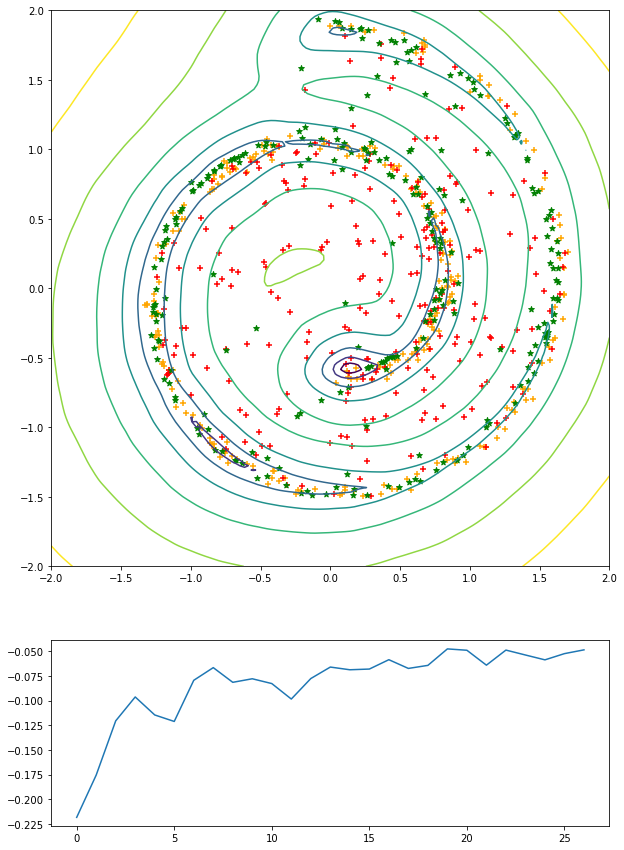

Method: improved training of WGAN (WGAN-GP) with penalty weight 1, one-sided penalty
[1350/2000] Loss_D: -0.048541 Loss_G: -0.169365 Loss_D_real: -0.222247 Loss_D_fake -0.172755 Loss_lip 0.000951


In [ ]:
# example of running multiple experiments
run_list_of_experiments({"n":20, "lc": 3, "pw": 1, "os": True, "niter":2000},
                        {"n":20, "lc": 3, "pw": 1, "os": False, "niter":2000},
                        {"n":20, "lc": 4, "pw": 1, "os": True, "pboth": False, "psym": True, "niter":2000},
                        {"n":20, "lc": 4, "pw": 1, "os": True, "pboth": True,  "psym": True, "niter":2000},
                        {"n":20, "lc": 4, "pw": 1, "os": False, "pboth": False,  "psym": True, "niter":2000},
                        {"n":20, "lc": 4, "pw": 1, "os": False, "pboth": True,  "psym": True, "niter":2000})

In [ ]:
run_experiment(lipschitz_constraint=1, onesided=True, penalty_weight=10)

Method: DRAGAN with penalty weight 3, one-sided penalty
[100/100] Loss_D: -0.222675 Loss_G: 5.351257 Loss_D_real: 5.084848 Loss_D_fake 5.343085 Loss_lip 0.035562


errD      errG  scoreD_real  scoreD_fake  lip_loss
iter run                                                        
1    1   -3.984171  2.996636    -1.338752    -1.338752  0.320971
     2   -3.504601  2.885448    -1.001217    -1.001217  0.417671
     3   -3.962936  3.517426    -1.065740    -1.065740  0.478983
     4   -3.180453  2.758745    -0.825582    -0.825582  0.406565
     5   -3.871509  2.808099    -1.263884    -1.263884  0.380126
     6   -4.098668  2.984791    -1.393889    -1.393889  0.311843
     7   -3.587006  3.293102    -0.712331    -0.712331  0.415450
     8   -4.272212  3.719148    -1.185104    -1.185104  0.417686
     9   -3.805371  2.367244    -1.914892    -1.914892  0.491174
     10  -3.719634  3.268989    -0.869752    -0.869752  0.432810
     11  -4.100415  3.594366    -0.829872    -0.829872  0.349332
     12  -3.818616  2.163101    -1.806492    -1.806492  0.303000
     13  -3.216051  2.247262    -1.301701    -1.301701  0.393015
     14  -3.460399  2.915695    -1.123541    -1.123541  0.538311
     15  -3.819531  3.601094    -0.667224    -0.667224  0.428667
     16  -4.085473  3.220165    -1.183155    -1.183155  0.347167
     17  -4.271955  2.651074    -1.950452    -1.950452  0.377846
     18  -4.066961  3.374413    -1.222628    -1.222628  0.391723
     19  -3.871905  2.981280    -1.270973    -1.270973  0.392966
     20  -3.837501  2.711942    -1.537341    -1.537341  0.383552
2    1   -3.854264  3.270792    -0.857206    -0.857206  0.385025
     2   -3.160740  3.575472    -0.159521    -0.159521  0.465247
     3   -4.005866  4.455515    -0.401454    -0.401454  0.787862
     4   -3.784122  4.079062    -0.245063    -0.245063  0.548434
     5   -4.131736  3.397649    -1.141995    -1.141995  0.538129
     6   -3.685205  3.954114    -0.475681    -0.475681  0.591669
     7   -3.249374  4.175657     0.466039     0.466039  0.461867
     8   -4.560664  4.885307    -0.266281    -0.266281  0.509853
     9   -3.882968  3.374974    -1.709363    -1.709363  1.129928
     10  -3.567844  4.484839     0.314367     0.314367  0.600383
...            ...       ...          ...          ...       ...
99   11  -0.219883  3.133610     2.968032     2.968032  0.037223
     12  -0.086814  1.762339     1.492794     1.492794  0.020167
     13  -0.177262  3.117187     3.019121     3.019121  0.040015
     14  -0.180427  5.249388     5.287431     5.287431  0.044294
     15  -0.177140  3.815068     3.749378     3.749378  0.016912
     16  -0.233126  5.032937     4.626196     4.626196  0.027493
     17  -0.150989  3.480009     3.207628     3.207628  0.059997
     18  -0.188741  6.679919     6.520314     6.520314  0.039148
     19  -0.146310  5.295567     4.949700     4.949700  0.042346
     20  -0.166687  5.464202     5.066318     5.066318  0.045693
100  1   -0.239331  5.242919     5.080154     5.080154  0.037737
     2   -0.242484  6.321984     6.036341     6.036341  0.040905
     3   -0.210657  5.468300     5.061306     5.061306  0.035370
     4   -0.255758  6.013158     5.326321     5.326321  0.054894
     5   -0.206929  4.060673     3.758294     3.758294  0.018126
     6   -0.235504  4.799881     4.343042     4.343042  0.066673
     7   -0.272954  2.985933     2.689564     2.689564  0.032493
     8   -0.241848  5.069668     4.689599     4.689599  0.055294
     9   -0.248409  3.462244     3.010043     3.010043  0.035279
     10  -0.201333  6.021212     5.310417     5.310417  0.074166
     11  -0.218367  3.137021     2.901391     2.901391  0.041500
     12  -0.158592  1.884753     1.705879     1.705879  0.014926
     13  -0.242273  3.285871     2.989525     2.989525  0.037421
     14  -0.242146  5.432574     5.091500     5.091500  0.047493
     15  -0.248692  4.216149     3.647726     3.647726  0.024460
     16  -0.266704  4.982326     4.689838     4.689838  0.056600
     17  -0.199547  3.743212     3.112310     3.112310  0.066765
     18  -0.236942  6.791902     6.383661     6.383661  0.034631
     19  -0.249282  5.284407     4.984448     4.9

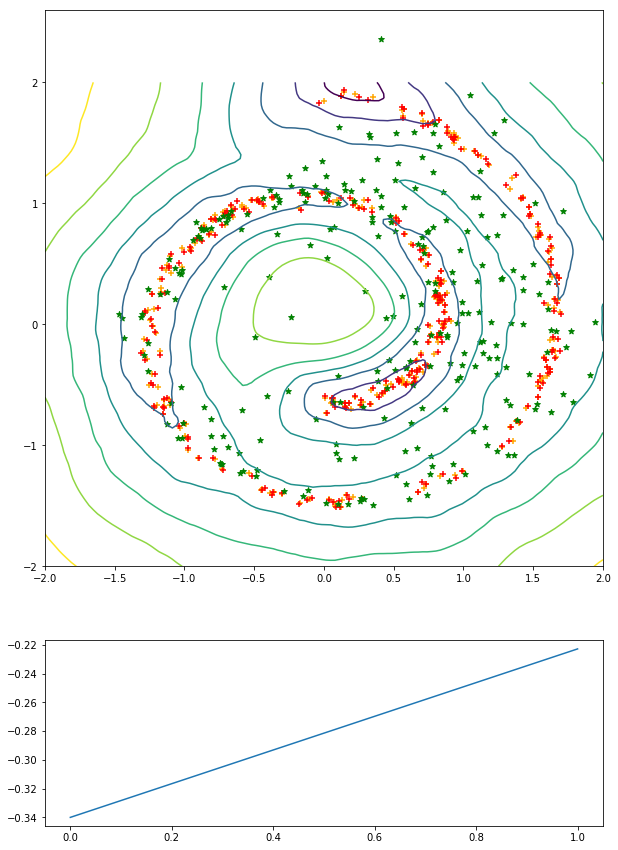

In [144]:
run_n_experiments(n=20, lipschitz_constraint=4, onesided=True, penalty_weight=3, perturb_symmetric=True, perturb_scale=0.1, niter=100)

In [ ]:
run_experiment(lipschitz_constraint=4, onesided=False, penalty_weight=3)

In [ ]:
run_experiment(lipschitz_constraint=6, onesided=False, penalty_weight=10)

In [ ]:
run_experiment(lipschitz_constraint=7, onesided=True, penalty_weight=100)

In [ ]:
run_experiment(lipschitz_constraint=5, onesided=True, penalty_weight=10)

I have [a small write-up of my conclusions](https://lernapparat.de/more-improved-wgan/).

More things to try:
- Explore why with high penalty, the (semi-) improved WGAN training becomes unstable beyond what is done in the [*more improved training* write-up](https://lernapparat.de/more-improved-wgan/).
- Systematically compare Improved vs. Semi-Improved Training of Wasserstein GAN.
  I am still unsure whether it might be preferrable to have the Lipschitz constant tested directly rather than using the gradient.
  In particular, we can implement a minimally less simple SLOGAN variant.
- Many authors discuss how batch normalisation is not good for GAN. Look at weight normalisation ([Xiang, Li: On the Effects of Batch and Weight Normalization in Generative Adversarial Networks](https://arxiv.org/abs/1704.03971)) and layer normalisation, but maybe beyond the toy examples.


I appreciate your feedback: Thomas Viehmann, tv@lernapparat.de